# Using Generated CAPTCHAS to train a CAPTCHA-breaking Neural Network

This is a series on the HackMIT puzzles. The previous puzzle is about generating inputs that maximizes output activation. This technique is called gradient ascent and is used famously by Google Deep Dream.

Puzzle 5 requires training an entire neural network to break captchas. Puzzlers are allowed to test 15000 answers to captchas and the goal is to achieve 66% (10000/15000) accuracy. Puzzlers are given an endpoint to download 1000 captcha jpegs each request.

Originally I wanted to avoid training a neural network(although it's not hard), I had never done it before. So I did some image processing and successfully turned the captcha into a very clean binary image. The segmentation techniques worked like a charm.

However, I failed to find an accurate OCR to convert individual characters to text. So I gave in and went back to the drawing board. The most straightforward way is to generated some captchas as training data. The image has to be very similar to what the actual captchas look like. So here I created a simple generator that outputs binary PIL Image(and then np.array) that roughly fits the shape and feel of the test data.

In [1]:
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
from string import ascii_lowercase, digits
from random import choice, random
import numpy as np
import os

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
alphanumeric = ascii_lowercase + digits

width, height, n_len, n_class = 100, 50, 4, len(alphanumeric)

# File loader

In [2]:
def fuzzy_loc(locs):
    acc = []
    for i,loc in enumerate(locs[:-1]):
        if locs[i+1] - loc < 8:
            continue
        else:
            acc.append(loc)
    return acc

def seg(img):
    arr = np.array(img, dtype=np.float)
    arr = arr.transpose()
    # arr = np.mean(arr, axis=2)
    arr = np.sum(arr, axis=1)
    locs = np.where(arr < arr.min() + 2)[0].tolist()
    locs = fuzzy_loc(locs)
    return locs
#     # for l in locs:
#     #     plt.axvline(x=l)
#     # plt.plot(np.arange(0,100), arr)
#     # plt.show()
#     locs += [100]
#     locs = [0] + locs

#     draw = ImageDraw.Draw(original_img)
#     for i in range(len(locs) - 1):
#         subimg = original_img.crop((locs[i], 0, locs[i+1], h))
#         print to_text(subimg)
#         # subimg.show()
#         # draw.line((locs[i],0,locs[i],h), fill=255)
#     original_img.show()

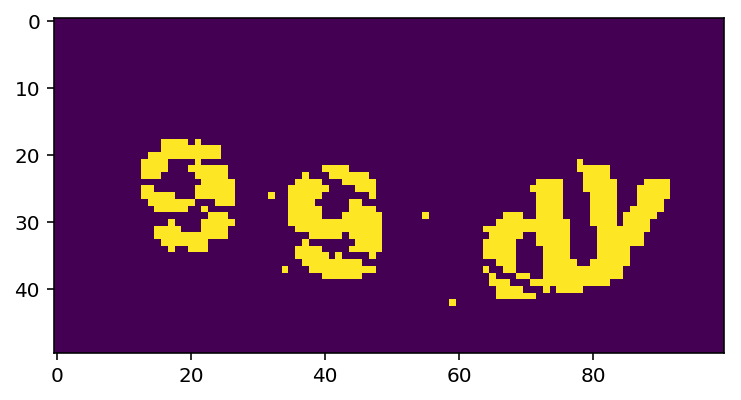

In [4]:
jpg_dir = './orig'
img_paths = [jpg_dir + '/' + i for i in os.listdir(jpg_dir)]
img_path = choice(img_paths)
imarr = np.array(Image.open(img_path).convert("1")).astype(float)
plt.imshow(imarr)

# Generator

In [12]:
noiseimg = np.array(Image.open("Average.png").convert("1"))
noiseimg = np.bitwise_not(noiseimg)
fnt = ImageFont.truetype('./arial-extra.otf', 26)
def gen_one():
    og = Image.new("1", (100,50))
    text = ''.join([choice(alphanumeric) for _ in range(4)])
    draw = ImageDraw.Draw(og)
    for i, t in enumerate(text):
        txt=Image.new('L', (40,40))
        d = ImageDraw.Draw(txt)
        d.text( (0, 0), t,  font=fnt, fill=255)
        if random() > 0.5:
            w=txt.rotate(-40*(random()-1),  expand=1)
            og.paste( w, (i*int(20) + int(25*random()), int(25+40*(random()-1))),  w)
        else:
            w=txt.rotate(40*(random()-1),  expand=1)
            og.paste( w, (i*int(20) + int(25*random()), int(30*random())),  w)

    segments = seg(og)
    if len(segments) != 4:
        return gen_one()
    ogarr = np.array(og)
    ogarr = np.bitwise_and(noiseimg, ogarr)
    ogarr = np.expand_dims(ogarr, axis=2).astype(float)
    ogarr = np.random.random(size=(50,100,1)) * ogarr
    ogarr = (ogarr > 0.0).astype(float)
    return ogarr, text

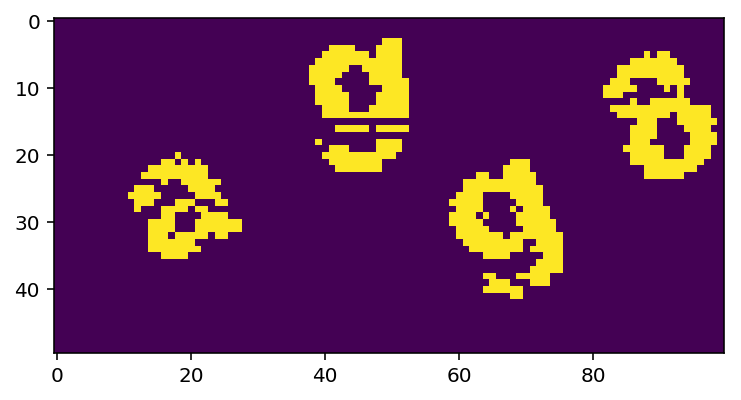

In [19]:
im, t = gen_one()
im = np.squeeze(im, 2)
plt.imshow(im)

# Batch Generator

In [7]:
def gen(batch_size=32):
    X = np.zeros((batch_size, height, width, 1), dtype=np.uint8)
    y = [np.zeros((batch_size, n_class), dtype=np.uint8) for i in range(n_len)]
    while True:
        for i in range(batch_size):
            im, random_str = gen_one()
            X[i] = im
            for j, ch in enumerate(random_str):
                y[j][i, :] = 0
                y[j][i, alphanumeric.find(ch)] = 1
        yield X, y

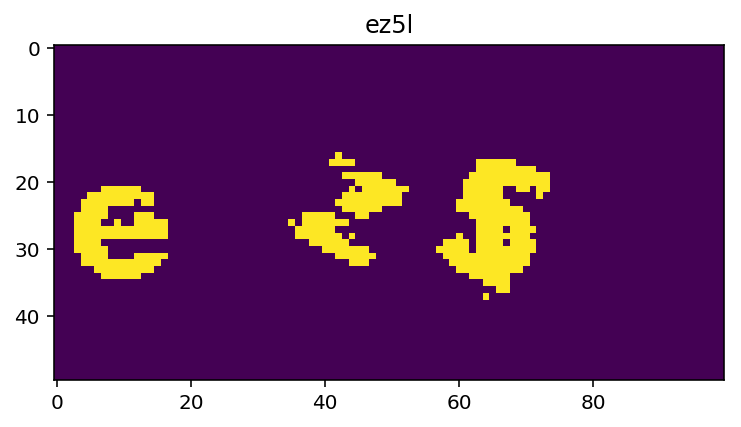

In [8]:
def decode(y):
    y = np.argmax(np.array(y), axis=2)[:,0]
    return ''.join([alphanumeric[x] for x in y])

X, y = next(gen(1))
plt.imshow(np.squeeze(X[0],2))
plt.title(decode(y))

In [9]:
from keras.models import *
from keras.layers import *

input_tensor = Input((height, width, 1))
x = input_tensor
for i in range(4):
    x = Conv2D(32*2**i, (2, 2), activation='relu')(x)
    x = Conv2D(32*2**i, (2, 2), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.2)(x)

x = Flatten()(x)
x = Dropout(0.5)(x)
x = [Dense(n_class, activation='softmax', name='c%d'%(i+1))(x) for i in range(4)]
model = Model(inputs=input_tensor, outputs=x)
model.load_weights("cnn.h5")



Using TensorFlow backend.


ValueError: Dimension 0 in both shapes must be equal, but are 2 and 64 for 'Assign' (op: 'Assign') with input shapes: [2,2,1,32], [64,1,2,2].

In [1479]:
from keras.optimizers import RMSprop
# rmsprop = RMSprop(lr=0.025, rho=0.9, epsilon=1e-08, decay=0.0)
# model.compile(loss='categorical_crossentropy',
#               optimizer=rmsprop,
#               metrics=['accuracy'])
model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])


In [1480]:
model.fit_generator(gen(), steps_per_epoch=50000, epochs=5,
                    validation_data=gen(), validation_steps=80)

Epoch 1/5
  502/50000 [..............................] - ETA: 1514s - loss: 1.7306 - c1_loss: 0.2356 - c2_loss: 0.4903 - c3_loss: 0.6378 - c4_loss: 0.3669 - c1_acc: 0.9375 - c2_acc: 0.8864 - c3_acc: 0.8576 - c4_acc: 0.9152

KeyboardInterrupt: 

# Infer

(-0.5, 99.5, 49.5, -0.5)

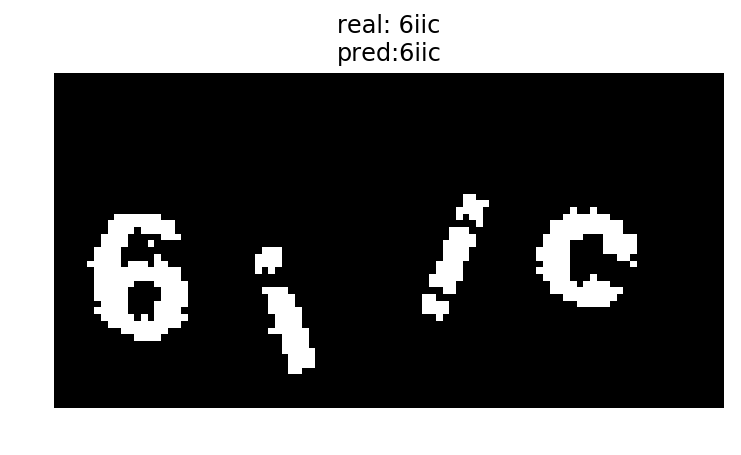

In [1485]:
X, y = next(gen(1))
y_pred = model.predict(X)
plt.title('real: %s\npred:%s'%(decode(y), decode(y_pred)))
plt.imshow(np.squeeze(X[0],axis=2), cmap='gray')
plt.axis('off')


In [1486]:
from tqdm import tqdm
def evaluate(model, batch_num=20):
    batch_acc = 0
    generator = gen()
    for i in tqdm(range(batch_num)):
        X, y = generator.next()
        y_pred = model.predict(X)
        batch_acc += np.mean(map(np.array_equal, np.argmax(y, axis=2).T, np.argmax(y_pred, axis=2).T))
    return batch_acc / batch_num

evaluate(model)

100%|██████████| 20/20 [00:00<00:00, 36.94it/s]


0.81562500000000004

In [1487]:
model.save('cnn.h5')

# Skip the ill-formed one to increase accuracy

Segment the image horizontally to make sure words are column based.

In [1415]:
def is_well_formed(img_path):
    original_img = Image.open(im)
    img = original_img.convert('1')

    return len(seg(img)) == 3

# Inferring with Real Data

[ 0.87833852]


(-0.5, 99.5, 49.5, -0.5)

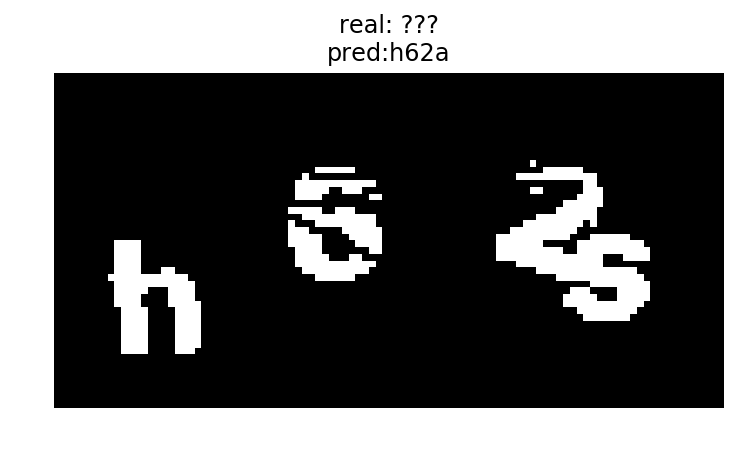

In [1507]:
jpg_dir = './orig'
img_paths = [jpg_dir + '/' + i for i in os.listdir(jpg_dir)]
path = choice(img_paths)

imarr = np.array(Image.open(path).convert('1')).astype(float)
imarr = np.expand_dims(imarr, axis = 2)
imarr = np.expand_dims(imarr, axis = 0)
y_pred = model.predict(imarr)
print np.max(y_pred[0],axis=1)
plt.title('real: ???\npred:%s'%(decode(y_pred)))
plt.imshow(np.squeeze(imarr[0],axis=2), cmap='gray')
plt.axis('off')


In [1377]:
def predict_production(img_path):
    imarr = np.array(Image.open(img_path).convert('1')).astype(float)
    imarr = np.expand_dims(imarr, axis = 2)
    imarr = np.expand_dims(imarr, axis = 0)
    y_pred = model.predict(imarr)
    return img_path[7:-4], decode(y_pred)

with open("outfile2", 'w') as f:
    for i, p in enumerate(img_paths):
        if i % 100 == 0:
            print i
        if is_well_formed(p):
            p, pred = predict_production(p)
            f.write(",".join([p, pred]))
            f.write("\n")

0


ValueError: could not convert string to float: ./jpgs/1ef0634e2890b324908bb4a15bedc6a6.jpg